LeNet5 model 

In [2]:
import pandas as pd 
import numpy as np 
import tqdm as notebook_tqdm


import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

import torch.optim as optim
from torch.optim import SGD
from torch.utils.data import DataLoader
import torchvision 
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
from torchvision import datasets 
from datetime import datetime

from torch.utils.data.sampler import SubsetRandomSampler

/volumes1/thesis/notebooks/notebook_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    torch.cuda.empty_cache()


In [4]:
# defining hyperparameters 
epochs = 10 
#epochs = 40   #the nn will train 40 times over all 50.000 images and validate itself with 12.000 images x 40 times) 
learning_rate = 0.0001 #how much the weight will be updated each time 
batch_size = 32 
classes = 43 
img_size = 32
random_seed = 42

Loading data 

In [5]:
def get_train_valid_loader(
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=2):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize((0.3403, 0.3121, 0.3214),
                                    (0.2724, 0.2608, 0.2669))

    # define transforms
    valid_transform = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.ToTensor(),
                                      ])
   
    train_transform = transforms.Compose([transforms.Resize((32,32)),
                                       transforms.ToTensor(),
                                       normalize])

    # load the dataset

    base_dataset = datasets.ImageFolder(
        root='/volumes1/thesis/notebooks/data/gtsrb/GTSRB/Training', transform=train_transform,
    )

    # TODO
    split_datasets = torch.utils.data.random_split(base_dataset, [0.20,0.8])
    global val_dataset 
    val_dataset = split_datasets[0]
    train_dataset = split_datasets[1]
    

    global num_train 
    num_train= len(train_dataset)
    indices = list(range(num_train))
    global split 
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    #train_idx, valid_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #valid_sampler = SubsetRandomSampler(valid_idx)


    global train_loader 
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = train_sampler
    )
    global valid_loader 
    valid_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = valid_sampler
    )

    return train_loader, valid_loader

print(get_train_valid_loader(batch_size = 64, augment = True, random_seed = 1))


(<torch.utils.data.dataloader.DataLoader object at 0x7f3f8b444fa0>, <torch.utils.data.dataloader.DataLoader object at 0x7f3eefae3dc0>)


Training function 

In [6]:
def get_accuracy(model, data_loader, device):
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [7]:
def plot_losses(train_losses, valid_losses):

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [8]:
# train function

def train(train_loader, model, criterion, optimizer, device):

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [9]:
# validation function, without a learning step (backward pass)

def validate(valid_loader, model, criterion, device):
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [10]:
# training function

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

Model 

In [11]:
# model function 
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [12]:

torch.manual_seed(random_seed)

model = LeNet5(classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

09:54:45 --- Epoch: 0	Train loss: 3.3951	Valid loss: 2.9724	Train accuracy: 23.85	Valid accuracy: 23.31
09:54:52 --- Epoch: 1	Train loss: 2.5789	Valid loss: 2.1893	Train accuracy: 39.82	Valid accuracy: 40.22
09:54:59 --- Epoch: 2	Train loss: 1.9568	Valid loss: 1.6994	Train accuracy: 52.71	Valid accuracy: 54.02
09:55:06 --- Epoch: 3	Train loss: 1.5372	Valid loss: 1.3328	Train accuracy: 64.20	Valid accuracy: 65.05
09:55:14 --- Epoch: 4	Train loss: 1.2200	Valid loss: 1.0703	Train accuracy: 72.95	Valid accuracy: 73.35
09:55:21 --- Epoch: 5	Train loss: 0.9917	Valid loss: 0.8813	Train accuracy: 79.08	Valid accuracy: 78.77
09:55:28 --- Epoch: 6	Train loss: 0.8224	Valid loss: 0.7392	Train accuracy: 83.24	Valid accuracy: 82.62
09:55:35 --- Epoch: 7	Train loss: 0.6923	Valid loss: 0.6294	Train accuracy: 86.34	Valid accuracy: 85.40
09:55:43 --- Epoch: 8	Train loss: 0.5909	Valid loss: 0.5434	Train accuracy: 88.48	Valid accuracy: 87.82
09:55:50 --- Epoch: 9	Train loss: 0.5108	Valid loss: 0.4751	Trai

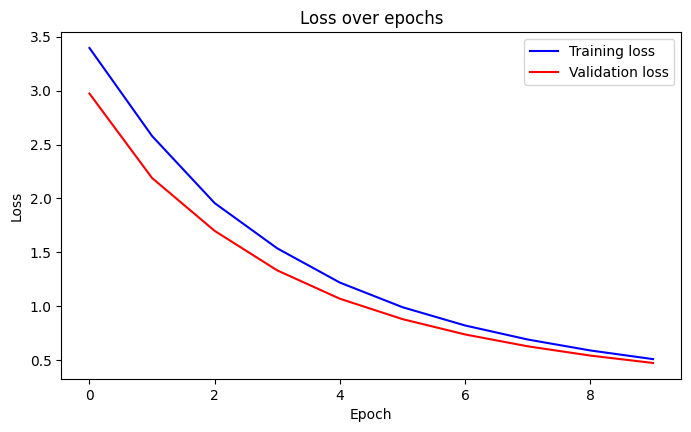

In [13]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)

# Find adversarial samples with ART.

In [34]:
# We have a trained model from the code above
# Put everything on CPU
model.to('cpu')

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=43, bias=True)
  )
)

### Find a single adversarial example

In [14]:
# loading dataset 
transforms = transforms.Compose([transforms.Resize((32, 32)),
    transforms.ToTensor()])
    
test_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'test', transform=transforms, download=True)

# train loader 
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
, shuffle=False, num_workers=2)

In [15]:
x, y_true = test_dataset[0]
x.shape, x.min(), x.max()

(torch.Size([3, 32, 32]), tensor(0.0392), tensor(0.7176))

What does X look like?

If we want to correctly display X, we need to first reverse the normalization transform defined above.

In [180]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

In [181]:
inverse_normalize = NormalizeInverse(mean=(0.3403, 0.3121, 0.3214), std=(0.2724, 0.2608, 0.2669))  # Same mean and std values as defined in the original transforms.

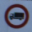

In [182]:
import torchvision
torchvision.transforms.ToPILImage()(x)

We will be looking for adversarial examples on the original inputs, not the normalized inputs. The original inputs (the ones that have not been normalized yet) have values between [0, 1]. The adversarial samples should also have values in the same range.

However, our model expects inputs that are normalized.

We therefore write a small wrapper around our model that accepts unnormalized inputs, but does the normalization before passing it to the original model. This allows ART to search for adversarial samples in the original [0,1] range.

In [40]:
class WrappedModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.trained_model = model  # "model" is our trained model
    self.trained_model.to("cpu")
    self.normalize = torchvision.transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))

  def forward(self, x: torch.Tensor):
    # x comes in as a Tensor of shape [3, 32, 32]
    # Manually add a batch dimension
    x = torch.unsqueeze(x, dim=0)
    # Shape of x is now [1, 3, 32, 32]
    # Normalize the input
    x_normalized = self.normalize(x)
    # Return only the logits
    logits, _ = self.trained_model(x_normalized)
    return logits

In [41]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier


In [42]:
# We again wrap our (already wrapped) model in a PyTorchClassifier, which ART knows how to use
classifier = PyTorchClassifier(
      model=WrappedModel(),
      clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
      loss=criterion,  # defined above
      optimizer=optimizer,  # defined above
      input_shape=(3, 32, 32),
      nb_classes=43,
      device_type="cpu"
)

In [103]:
x.device

device(type='cpu')

FGSM attack - 1st attempt 

In [186]:
# Define an ART attack and create a generator 
attack = FastGradientMethod(estimator=classifier, eps=0.1)
#x_test_adv = attack.generate(x_test.numpy())

#predictions = classifier.predict(x_test_adv)
#predictions = torch.from_numpy(predictions)


In [187]:
X = x.numpy()

In [188]:
# ART expects inputs to be numpy arrays!
# Find adversarial samples in the original input domain - which is unnormalized
benign_x = inverse_normalize(x)
benign_x = benign_x.cpu().numpy()
type(benign_x), benign_x.min(), benign_x.max()

(numpy.ndarray, 0.3284639, 0.51294005)

In [189]:
benign_x.shape

(3, 32, 32)

In [190]:
x_adversarial = attack.generate(benign_x)    # lijst van maken

In [191]:
x_adversarial.shape

(3, 32, 32)

In [192]:
x_adversarial.min(), x_adversarial.max()

(0.23050943, 0.6129401)

### Check the predictions

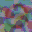

In [193]:
torchvision.transforms.ToPILImage()(torch.Tensor(x_adversarial))

In [194]:
test_model = WrappedModel()


In [195]:
torch.argmax(test_model(torch.Tensor(x_adversarial)))

tensor(13)

In [196]:
y_true

16

In [74]:
from os import listdir
import os 

In [ ]:
#def get_accuracy_adv(data_loader):
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to('cpu')
            y_true = y_true.to('cpu')

            classifier = PyTorchClassifier(
            model=WrappedModel(),
            clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
            loss=criterion,  # defined above
            optimizer=optimizer,  # defined above
            input_shape=(3, 32, 32),
            nb_classes=43,
            device_type="cpu"
            )
            attack = FastGradientMethod(estimator=classifier, eps=0.1)
            x_test_adv = X.cpu().numpy()
            x_adversarial = attack.generate(x_test_adv)
            test_model = WrappedModel()

            _, y_prob = test_model(X)
            _, predicted_labels = torch.argmax(test_model(torch.Tensor(x_adversarial, 1)))
            
            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [ ]:
#get_accuracy_adv(test_loader)

In [ ]:
#def generate_attack(dataloader):
  open('/volumes1/thesis/notebooks/data/gtsrb/GTSRB/adversarial_samples')
  
  true_labels = []


  for X, y_true in dataloader:
    X = x.to('cpu')
    y_true = y_true.to('çpu')

  
    classifier = PyTorchClassifier(
      model=WrappedModel(),
      clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
      loss=criterion,  # defined above
      optimizer=optimizer,  # defined above
      input_shape=(3, 32, 32),
      nb_classes=43,
      device_type="cpu"
    )
    # Define an ART attack and create a generator 
    attack = FastGradientMethod(estimator=classifier, eps=0.1)

    # Find an adversarial sample
    # ART expects inputs to be numpy arrays!

    # Find adversarial samples in the original input domain - which is unnormalize
    benign_x = x.cpu().numpy()  # convert torch to numpy
    #type(benign_x), benign_x.min(), benign_x.max()
    x_adversarial = attack.generate(benign_x) 
    torchvision.transforms.ToPILImage()(torch.Tensor(x_adversarial))
    #attacks.append(adversarial_sample)
    test_model = WrappedModel()
    prediction = torch.argmax(test_model(torch.Tensor(x_adversarial)))
    
    accuracy = get_accuracy_adv()


    close('/volumes1/thesis/notebooks/data/gtsrb/GTSRB/adversarial_samples')
    return prediction, y, correct_pred, accuracy, true_labels



In [ ]:
#generate_attack(test_dataset)

In [ ]:
#def display_adv_samples(x):
        
    #return torchvision.transforms.ToPILImage()(torch.Tensor(x))

In [ ]:
#display_adv_samples(x_test)

In [ ]:
#import cv2 

In [ ]:
##for x,y in test_loader:
    #print(cv2.imread(x))

Carlini & Wagner attack - 1st attempt 

In [43]:
from art.attacks.evasion import CarliniL0Method, CarliniL2Method, CarliniLInfMethod, CarliniWagnerASR

In [44]:
x.numpy()

array([[[0.45490196, 0.45490196, 0.4627451 , ..., 0.39607844,
         0.39215687, 0.35686275],
        [0.45490196, 0.45490196, 0.45882353, ..., 0.47058824,
         0.4745098 , 0.47058824],
        [0.45882353, 0.45882353, 0.4509804 , ..., 0.4745098 ,
         0.47843137, 0.47058824],
        ...,
        [0.45882353, 0.45490196, 0.45490196, ..., 0.45490196,
         0.45490196, 0.4627451 ],
        [0.45490196, 0.44705883, 0.44705883, ..., 0.44705883,
         0.45490196, 0.4509804 ],
        [0.4392157 , 0.4392157 , 0.4627451 , ..., 0.4509804 ,
         0.45882353, 0.44705883]],

       [[0.54901963, 0.5411765 , 0.5411765 , ..., 0.4627451 ,
         0.4745098 , 0.43529412],
        [0.5529412 , 0.54901963, 0.5529412 , ..., 0.5568628 ,
         0.5568628 , 0.54901963],
        [0.5568628 , 0.5529412 , 0.54901963, ..., 0.5647059 ,
         0.5647059 , 0.56078434],
        ...,
        [0.5372549 , 0.5294118 , 0.5294118 , ..., 0.5372549 ,
         0.53333336, 0.54509807],
        [0.5

In [ ]:
class CarliniL2Method(art.attacks.evasion.CarliniL2Method):
    def __init__: 
        classifier = classifier 
    

In [45]:
cw0_attack = CarliniL0Method(classifier, learning_rate = 0.0001)
cw2_attack = CarliniL2Method(classifier, learning_rate = 0.0001)

In [46]:
cw0_attack.generate(x.numpy())

RuntimeError: output with shape [1, 1, 32, 32] doesn't match the broadcast shape [1, 3, 32, 32]

In [20]:
def attack_targeted(model, train_loader, x0, y0, target, alpha = 0.1, beta = 0.001, iterations = 1000, batch_size = 10):
    """ Attack the original image and return adversarial example of target t
        model: (pytorch model)
        train_dataset: set of training data
        (x0, y0): original image
        t: target
    """
    o_alpha = alpha
    if (model.predict(x0) != y0):
        print("Fail to classify the image. No need to attack.")
        return x0
    # STEP I: find initial direction (theta, g_theta)
    ''' 
    image, label = Variable(x0.cuda()), y0.cuda() 
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)
    target = torch.randperm(10)
    #print(predicted!=y0).nonzero()
    '''
    num_samples = 1000 
    best_theta, g_theta = None, float('inf')
    query_count = 0

    #print("Searching for the initial direction on %d samples: " % (num_samples))
    timestart = time.time()
    #samples = set(random.sample(range(len(train_dataset)), num_samples))
    b_train_size = 1000
    b_best_lbd = float('inf')
    dim1 = x0.size()[0]
    dim3 = x0.size()[2]
    #for index in range(batch_size):
    for i, (xi, yi) in enumerate(train_loader):
        if i == 1:
            break
        xi,yi=xi.cuda(),yi.cuda()
        #temp_x0, temp_y0 = x0[index], y0[index]
        temp_x0 = x0 
        #temp_x0 = temp_x0.expand(100,1,28,28)
            
        #b_target = torch.LongTensor([target[index]]).expand(100).cuda()
        #b_target = torch.LongTensor([target]).expand(b_train_size).cuda()
        b_index = ( target == yi).nonzero().squeeze()
        if len(b_index.size()) == 0:
            continue
        xi = xi[b_index]
        #b_target = b_target[b_index]
        temp_x0 = temp_x0.expand(xi.size()).cuda()
        theta = xi - temp_x0
        initial_lbd = torch.norm(torch.norm(torch.norm(theta,2,1),2,1),2,1)
        initial_lbd = initial_lbd.unsqueeze(1).unsqueeze(2).expand(xi.size()[0],dim1,dim3).unsqueeze(3).expand(xi.size()[0],dim1,dim3,dim3)
        theta /= initial_lbd
        lbd, query_count = initial_fine_grained_binary_search_targeted(model, temp_x0, target, theta, initial_lbd)
        #print(lbd)    
        best_lbd, best_index = torch.min(lbd,0)
        #print(best_lbd)
        best_theta = theta[best_index]
        if best_lbd[0] < b_best_lbd:
            
            #print(model.predict(x0.cuda()+best_lbd*best_theta))
            b_best_lbd = best_lbd[0]
            b_best_theta = best_theta.clone()
            print("--------> Found g() %.4f" %b_best_lbd)

    best_theta, g_theta = b_best_theta.cpu(), b_best_lbd
     
    #print(model.predict(x0+g_theta*best_theta))
    timeend = time.time()
    print("==========> Found best distortion %.4f in %.4f seconds using %d queries" % (b_best_lbd, timeend-timestart, query_count))


    # STEP II: seach for optimal
    timestart = time.time()
    g1 = 1.0
    theta, g2 = best_theta.clone(), g_theta
    print(model.predict(x0+theta*g2))
    opt_count = 0
    torch.manual_seed(0)
    for i in range(iterations):
        #alpha = 1e-3
        #beta = 1e-3
        u = torch.randn(theta.size())
        u = u/torch.norm(u)
        g2, count = fine_grained_binary_search_local_targeted(model, x0, target, theta, initial_lbd = g2)
        opt_count += count
        ttt = theta+beta * u
        ttt = ttt/torch.norm(ttt)
        ttt = ttt.type(torch.FloatTensor)
        g1, count = fine_grained_binary_search_local_targeted(model, x0, target, ttt, initial_lbd = g2)
        opt_count += count
        temp_output = model.predict(x0+g2*theta)
        if (i+1)%100 == 0:
            print("Iteration %3d: g(theta + beta*u) = %.4f g(theta) = %.4f distortion %.4f num_queries %d alpha %.5f beta %.5f output %d" % (i+1, g1, g2, g2, opt_count, alpha, beta, temp_output))
        #if (i+1)%500 ==0:
        #    alpha = alpha*2 

        gradient = (g1-g2)/torch.norm(ttt-theta) * u
        temp_theta = theta - alpha*gradient
        temp_theta /= torch.norm(temp_theta)
        g3, count = fine_grained_binary_search_local_targeted(model, x0, target, temp_theta, initial_lbd = g2)
        if g3 > g1:
            #print("aa")
            theta = ttt
            #print(fine_grained_binary_search_targeted(model, x0, target, ttt, initial_lbd = g2))
        else:
            if g3>g2:
                theta.sub_(o_alpha*gradient)
            else:
                theta.sub_(alpha*gradient)
            theta /= torch.norm(theta)

    g2, count = fine_grained_binary_search_local_targeted(model, x0, target, theta, initial_lbd = g2)
    #distorch = torch.norm(g2*theta)
    out_target = model.predict(x0 + g2*theta)  # should be the target
    timeend = time.time()
    print("\nAdversarial Example Targeted %d Found Successfully: distortion %.4f target %d queries %d alpha %.5f beta %.5f \nTime: %.4f seconds" % (target, g2, out_target, query_count + opt_count, alpha, beta, timeend-timestart))
    return x0 + g2*theta


In [213]:
attack_targeted(model, test_loader, x, y_true, target, alpha = 0.1, beta = 0.001, iterations = 1000, batch_size = 10)

NameError: name 'target' is not defined

In [156]:

cw0_attack_adversarial = cw0_attack.generate(X)
cw2_attack_adversarial = cw2_attack.generate(X)

RuntimeError: output with shape [1, 1, 32, 32] doesn't match the broadcast shape [1, 3, 32, 32]

In [158]:
def predict(net, inputs):
    """
    Predict labels. The cuda state of `net` decides that of the returned
    prediction tensor.

    :param net: the network
    :param inputs: the input tensor (non Variable), of dimension [B x C x W x H]
    :return: prediction tensor (LongTensor), of dimension [B]
    """
    inputs = (net, inputs)[0]
    inputs_var = Variable(inputs)
    outputs_var = net(inputs_var)
    predictions = torch.max(outputs_var.data, dim=1)[1]
    return predictions

In [21]:
from operator import methodcaller
from torch.autograd import Variable


def get_cuda_state(obj):
    """
    Get cuda state of any object.

    :param obj: an object (a tensor or an `torch.nn.Module`)
    :raise TypeError:
    :return: True if the object or the parameter set of the object
             is on GPU
    """
    if isinstance(obj, nn.Module):
        try:
            return next(obj.parameters()).is_cuda
        except StopIteration:
            return None
    elif hasattr(obj, 'is_cuda'):
        return obj.is_cuda
    else:
        raise TypeError('unrecognized type ({}) in args'.format(type(obj)))


def is_cuda_consistent(*args):
    """
    See if the cuda states are consistent among variables (of type either
    tensors or torch.autograd.Variable). For example,

        import torch
        from torch.autograd import Variable
        import torch.nn as nn

        net = nn.Linear(512, 10)
        tensor = torch.rand(10, 10).cuda()
        assert not is_cuda_consistent(net=net, tensor=tensor)

    :param args: the variables to test
    :return: True if len(args) == 0 or the cuda states of all elements in args
             are consistent; False otherwise
    """
    result = dict()
    for v in args:
        cur_cuda_state = get_cuda_state(v)
        cuda_state = result.get('cuda', cur_cuda_state)
        if cur_cuda_state is not cuda_state:
            return False
        result['cuda'] = cur_cuda_state
    return True

def make_cuda_consistent(refobj, *args):
    """
    Attempt to make the cuda states of args consistent with that of ``refobj``.
    If any element of args is a Variable and the cuda state of the element is
    inconsistent with ``refobj``, raise ValueError, since changing the cuda state
    of a Variable involves rewrapping it in a new Variable, which changes the
    semantics of the code.

    :param refobj: either the referential object or the cuda state of the
           referential object
    :param args: the variables to test
    :return: tuple of the same data as ``args`` but on the same device as
             ``refobj``
    """
    ref_cuda_state = refobj if type(refobj) is bool else get_cuda_state(refobj)
    if ref_cuda_state is None:
        raise ValueError('cannot determine the cuda state of `refobj` ({})'
                .format(refobj))
    move_to_device = methodcaller('cuda' if ref_cuda_state else 'cpu')

    result_args = list()
    for v in args:
        cuda_state = get_cuda_state(v)
        if cuda_state != ref_cuda_state:
            if isinstance(v, Variable):
                raise ValueError('cannot change cuda state of a Variable')
            elif isinstance(v, nn.Module):
                move_to_device(v)
            else:
                v = move_to_device(v)
        result_args.append(v)
    return tuple(result_args)

def predict(net, inputs):
    """
    Predict labels. The cuda state of `net` decides that of the returned
    prediction tensor.

    :param net: the network
    :param inputs: the input tensor (non Variable), of dimension [B x C x W x H]
    :return: prediction tensor (LongTensor), of dimension [B]
    """
    inputs = make_cuda_consistent(net, inputs)[0]
    inputs_var = Variable(inputs)
    outputs_var = net(inputs_var)
    predictions = torch.max(outputs_var.data, dim=1)[1]
    return predictions

In [22]:
"""
Carlini-Wagner attack (http://arxiv.org/abs/1608.04644).

Referential implementation:

- https://github.com/carlini/nn_robust_attacks.git (the original implementation)
- https://github.com/rwightman/pytorch-nips2017-attack-example.git
"""
import operator as op
from typing import Union, Tuple
from torch.autograd import Variable


def _var2numpy(var):
    """
    Make Variable to numpy array. No transposition will be made.

    :param var: Variable instance on whatever device
    :type var: Variable
    :return: the corresponding numpy array
    :rtype: np.ndarray
    """
    return var.data.cpu().numpy()


def atanh(x, eps=1e-6):
    """
    The inverse hyperbolic tangent function, missing in pytorch.

    :param x: a tensor or a Variable
    :param eps: used to enhance numeric stability
    :return: :math:`\\tanh^{-1}{x}`, of the same type as ``x``
    """
    x = x * (1 - eps)
    return 0.5 * torch.log((1.0 + x) / (1.0 - x))

def to_tanh_space(x, box):
    # type: (Union[Variable, torch.FloatTensor], Tuple[float, float]) -> Union[Variable, torch.FloatTensor]
    """
    Convert a batch of tensors to tanh-space. This method complements the
    implementation of the change-of-variable trick in terms of tanh.

    :param x: the batch of tensors, of dimension [B x C x H x W]
    :param box: a tuple of lower bound and upper bound of the box constraint
    :return: the batch of tensors in tanh-space, of the same dimension;
             the returned tensor is on the same device as ``x``
    """
    _box_mul = (box[1] - box[0]) * 0.5
    _box_plus = (box[1] + box[0]) * 0.5
    return atanh((x - _box_plus) / _box_mul)

def from_tanh_space(x, box):
    # type: (Union[Variable, torch.FloatTensor], Tuple[float, float]) -> Union[Variable, torch.FloatTensor]
    """
    Convert a batch of tensors from tanh-space to oridinary image space.
    This method complements the implementation of the change-of-variable trick
    in terms of tanh.

    :param x: the batch of tensors, of dimension [B x C x H x W]
    :param box: a tuple of lower bound and upper bound of the box constraint
    :return: the batch of tensors in ordinary image space, of the same
             dimension; the returned tensor is on the same device as ``x``
    """
    _box_mul = (box[1] - box[0]) * 0.5
    _box_plus = (box[1] + box[0]) * 0.5
    return torch.tanh(x) * _box_mul + _box_plus


class L2Adversary(object):
    """
    The L2 attack adversary. To enforce the box constraint, the
    change-of-variable trick using tanh-space is adopted.

    The loss function to optimize:

    .. math::
        \\|\\delta\\|_2^2 + c \\cdot f(x + \\delta)

    where :math:`f` is defined as

    .. math::
        f(x') = \\max\\{0, (\\max_{i \\ne t}{Z(x')_i} - Z(x')_t) \\cdot \\tau + \\kappa\\}

    where :math:`\\tau` is :math:`+1` if the adversary performs targeted attack;
    otherwise it's :math:`-1`.

    Usage::

        attacker = L2Adversary()
        # inputs: a batch of input tensors
        # targets: a batch of attack targets
        # model: the model to attack
        advx = attacker(model, inputs, targets)


    The change-of-variable trick
    ++++++++++++++++++++++++++++

    Let :math:`a` be a proper affine transformation.

    1. Given input :math:`x` in image space, map :math:`x` to "tanh-space" by

    .. math:: \\hat{x} = \\tanh^{-1}(a^{-1}(x))

    2. Optimize an adversarial perturbation :math:`m` without constraint in the
    "tanh-space", yielding an adversarial example :math:`w = \\hat{x} + m`; and

    3. Map :math:`w` back to the same image space as the one where :math:`x`
    resides:

    .. math::
        x' = a(\\tanh(w))

    where :math:`x'` is the adversarial example, and :math:`\\delta = x' - x`
    is the adversarial perturbation.

    Since the composition of affine transformation and hyperbolic tangent is
    strictly monotonic, $\\delta = 0$ if and only if $m = 0$.

    Symbols used in docstring
    +++++++++++++++++++++++++

    - ``B``: the batch size
    - ``C``: the number of channels
    - ``H``: the height
    - ``W``: the width
    - ``M``: the number of classes
    """

    def __init__(self, targeted=True, confidence=0.0, c_range=(1e-3, 1e10),
                 search_steps=5, max_steps=1000, abort_early=True,
                 box=(-1., 1.), optimizer_lr=1e-2, init_rand=False):
        """
        :param targeted: ``True`` to perform targeted attack in ``self.run``
               method
        :type targeted: bool
        :param confidence: the confidence constant, i.e. the $\\kappa$ in paper
        :type confidence: float
        :param c_range: the search range of the constant :math:`c`; should be a
               tuple of form (lower_bound, upper_bound)
        :type c_range: Tuple[float, float]
        :param search_steps: the number of steps to perform binary search of
               the constant :math:`c` over ``c_range``
        :type search_steps: int
        :param max_steps: the maximum number of optimization steps for each
               constant :math:`c`
        :type max_steps: int
        :param abort_early: ``True`` to abort early in process of searching for
               :math:`c` when the loss virtually stops increasing
        :type abort_early: bool
        :param box: a tuple of lower bound and upper bound of the box
        :type box: Tuple[float, float]
        :param optimizer_lr: the base learning rate of the Adam optimizer used
               over the adversarial perturbation in clipped space
        :type optimizer_lr: float
        :param init_rand: ``True`` to initialize perturbation to small Gaussian;
               False is consistent with the original paper, where the
               perturbation is initialized to zero
        :type init_rand: bool
        :rtype: None

        Why to make ``box`` default to (-1., 1.) rather than (0., 1.)? TL;DR the
        domain of the problem in pytorch is [-1, 1] instead of [0, 1].
        According to Xiang Xu (samxucmu@gmail.com)::

        > The reason is that in pytorch a transformation is applied first
        > before getting the input from the data loader. So image in range [0,1]
        > will subtract some mean and divide by std. The normalized input image
        > will now be in range [-1,1]. For this implementation, clipping is
        > actually performed on the image after normalization, not on the
        > original image.

        Why to ``optimizer_lr`` default to 1e-2? The optimizer used in Carlini's
        code adopts 1e-2. In another pytorch implementation
        (https://github.com/rwightman/pytorch-nips2017-attack-example.git),
        though, the learning rate is set to 5e-4.
        """
        if len(c_range) != 2:
            raise TypeError('c_range ({}) should be of form '
                            'tuple([lower_bound, upper_bound])'
                            .format(c_range))
        if c_range[0] >= c_range[1]:
            raise ValueError('c_range lower bound ({}) is expected to be less '
                             'than c_range upper bound ({})'.format(*c_range))
        if len(box) != 2:
            raise TypeError('box ({}) should be of form '
                            'tuple([lower_bound, upper_bound])'
                            .format(box))
        if box[0] >= box[1]:
            raise ValueError('box lower bound ({}) is expected to be less than '
                             'box upper bound ({})'.format(*box))
        self.targeted = targeted
        self.confidence = float(confidence)
        self.c_range = (float(c_range[0]), float(c_range[1]))
        self.binary_search_steps = search_steps
        self.max_steps = max_steps
        self.abort_early = abort_early
        self.ae_tol = 1e-4  # tolerance of early abort
        self.box = tuple(map(float, box))  # type: Tuple[float, float]
        self.optimizer_lr = optimizer_lr

        # `self.init_rand` is not in Carlini's code, it's an attempt in the
        # referencing pytorch implementation to improve the quality of attacks.
        self.init_rand = init_rand

        # Since the larger the `scale_const` is, the more likely a successful
        # attack can be found, `self.repeat` guarantees at least attempt the
        # largest scale_const once. Moreover, since the optimal criterion is the
        # L2 norm of the attack, and the larger `scale_const` is, the larger
        # the L2 norm is, thus less optimal, the last attempt at the largest
        # `scale_const` won't ruin the optimum ever found.
        self.repeat = (self.binary_search_steps >= 10)

    def __call__(self, model, inputs, targets, to_numpy=True):
        """
        Produce adversarial examples for ``inputs``.

        :param model: the model to attack
        :type model: nn.Module
        :param inputs: the original images tensor, of dimension [B x C x H x W].
               ``inputs`` can be on either CPU or GPU, but it will eventually be
               moved to the same device as the one the parameters of ``model``
               reside
        :type inputs: torch.FloatTensor
        :param targets: the original image labels, or the attack targets, of
               dimension [B]. If ``self.targeted`` is ``True``, then ``targets``
               is treated as the attack targets, otherwise the labels.
               ``targets`` can be on either CPU or GPU, but it will eventually
               be moved to the same device as the one the parameters of
               ``model`` reside
        :type targets: torch.LongTensor
        :param to_numpy: True to return an `np.ndarray`, otherwise,
               `torch.FloatTensor`
        :type to_numpy: bool
        :return: the adversarial examples on CPU, of dimension [B x C x H x W]
        """
        # sanity check
        #assert isinstance(model, nn.Module)
        #assert len(inputs.size()) == 4
        #assert len(targets.size()) == 1

        # get a copy of targets in numpy before moving to GPU, used when doing
        # the binary search on `scale_const`
        targets_np = targets.clone().cpu().numpy()  # type: np.ndarray

        # the type annotations here are used only for type hinting and do
        # not indicate the actual type (cuda or cpu); same applies to all codes
        # below
        inputs = (model, inputs)[0]  # type: torch.FloatTensor
        targets = (model, targets)[0]  # type: torch.FloatTensor

        # run the model a little bit to get the `num_classes`
        num_classes = model(Variable(inputs[0][None, :], requires_grad=False)).size(1)  # type: int
        batch_size = inputs.size(0)  # type: int

        # `lower_bounds_np`, `upper_bounds_np` and `scale_consts_np` are used
        # for binary search of each `scale_const` in the batch. The element-wise
        # inquality holds: lower_bounds_np < scale_consts_np <= upper_bounds_np
        lower_bounds_np = np.zeros(batch_size)
        upper_bounds_np = np.ones(batch_size) * self.c_range[1]
        scale_consts_np = np.ones(batch_size) * self.c_range[0]

        # Optimal attack to be found.
        # The three "placeholders" are defined as:
        # - `o_best_l2`: the least L2 norms
        # - `o_best_l2_ppred`: the perturbed predictions made by the adversarial
        #    perturbations with the least L2 norms
        # - `o_best_advx`: the underlying adversarial example of
        #   `o_best_l2_ppred`
        o_best_l2 = np.ones(batch_size) * np.inf
        o_best_l2_ppred = -np.ones(batch_size)
        o_best_advx = inputs.clone().cpu().numpy()  # type: np.ndarray

        # convert `inputs` to tanh-space
        inputs_tanh = self._to_tanh_space(inputs)  # type: torch.FloatTensor
        inputs_tanh_var = Variable(inputs_tanh, requires_grad=False)

        # the one-hot encoding of `targets`
        targets_oh = torch.zeros(targets.size() + (num_classes,))  # type: torch.FloatTensor
        targets_oh = (model, targets_oh)[0]
        targets_oh.scatter_(1, targets.unsqueeze(1), 1.0)
        targets_oh_var = Variable(targets_oh, requires_grad=False)

        # the perturbation variable to optimize.
        # `pert_tanh` is essentially the adversarial perturbation in tanh-space.
        # In Carlini's code it's denoted as `modifier`
        pert_tanh = torch.zeros(inputs.size())  # type: torch.FloatTensor
        if self.init_rand:
            nn.init.normal(pert_tanh, mean=0, std=1e-3)
        pert_tanh = (model, pert_tanh)[0]
        pert_tanh_var = Variable(pert_tanh, requires_grad=True)

        optimizer = optim.Adam([pert_tanh_var], lr=self.optimizer_lr)
        for sstep in range(self.binary_search_steps):
            if self.repeat and sstep == self.binary_search_steps - 1:
                scale_consts_np = upper_bounds_np
            scale_consts = torch.from_numpy(np.copy(scale_consts_np)).float()  # type: torch.FloatTensor
            scale_consts = (model, scale_consts)[0]
            scale_consts_var = Variable(scale_consts, requires_grad=False)
            print('Using scale consts:', list(scale_consts_np))

            # the minimum L2 norms of perturbations found during optimization
            best_l2 = np.ones(batch_size) * np.inf
            # the perturbed predictions corresponding to `best_l2`, to be used
            # in binary search of `scale_const`
            best_l2_ppred = -np.ones(batch_size)
            # previous (summed) batch loss, to be used in early stopping policy
            prev_batch_loss = np.inf  # type: float
            for optim_step in range(self.max_steps):
                batch_loss, pert_norms_np, pert_outputs_np, advxs_np = \
                    self._optimize(model, optimizer, inputs_tanh_var,
                                   pert_tanh_var, targets_oh_var,
                                   scale_consts_var)
                if optim_step % 10 == 0: print('batch [{}] loss: {}'.format(optim_step, batch_loss)) 

                if self.abort_early and not optim_step % (self.max_steps // 10):
                    if batch_loss > prev_batch_loss * (1 - self.ae_tol):
                        break
                    prev_batch_loss = batch_loss

                # update best attack found during optimization
                pert_predictions_np = np.argmax(pert_outputs_np, axis=1)
                comp_pert_predictions_np = np.argmax(
                        self._compensate_confidence(pert_outputs_np,
                                                    targets_np),
                        axis=1)
                for i in range(batch_size):
                    l2 = pert_norms_np[i]
                    cppred = comp_pert_predictions_np[i]
                    ppred = pert_predictions_np[i]
                    tlabel = targets_np[i]
                    ax = advxs_np[i]
                    if self._attack_successful(cppred, tlabel):
                        assert cppred == ppred
                        if l2 < best_l2[i]:
                            best_l2[i] = l2
                            best_l2_ppred[i] = ppred
                        if l2 < o_best_l2[i]:
                            o_best_l2[i] = l2
                            o_best_l2_ppred[i] = ppred
                            o_best_advx[i] = ax

            # binary search of `scale_const`
            for i in range(batch_size):
                tlabel = targets_np[i]
                assert best_l2_ppred[i] == -1 or \
                       self._attack_successful(best_l2_ppred[i], tlabel)
                assert o_best_l2_ppred[i] == -1 or \
                       self._attack_successful(o_best_l2_ppred[i], tlabel)
                if best_l2_ppred[i] != -1:
                    # successful; attempt to lower `scale_const` by halving it
                    if scale_consts_np[i] < upper_bounds_np[i]:
                        upper_bounds_np[i] = scale_consts_np[i]
                    # `upper_bounds_np[i] == c_range[1]` implies no solution
                    # found, i.e. upper_bounds_np[i] has never been updated by
                    # scale_consts_np[i] until
                    # `scale_consts_np[i] > 0.1 * c_range[1]`
                    if upper_bounds_np[i] < self.c_range[1] * 0.1:
                        scale_consts_np[i] = (lower_bounds_np[i] + upper_bounds_np[i]) / 2
                else:
                    # failure; multiply `scale_const` by ten if no solution
                    # found; otherwise do binary search
                    if scale_consts_np[i] > lower_bounds_np[i]:
                        lower_bounds_np[i] = scale_consts_np[i]
                    if upper_bounds_np[i] < self.c_range[1] * 0.1:
                        scale_consts_np[i] = (lower_bounds_np[i] + upper_bounds_np[i]) / 2
                    else:
                        scale_consts_np[i] *= 10

        if not to_numpy:
            o_best_advx = torch.from_numpy(o_best_advx).float()
        return o_best_advx

    def _optimize(self, model, optimizer, inputs_tanh_var, pert_tanh_var,
                  targets_oh_var, c_var):
        """
        Optimize for one step.

        :param model: the model to attack
        :type model: nn.Module
        :param optimizer: the Adam optimizer to optimize ``modifier_var``
        :type optimizer: optim.Adam
        :param inputs_tanh_var: the input images in tanh-space
        :type inputs_tanh_var: Variable
        :param pert_tanh_var: the perturbation to optimize in tanh-space,
               ``pert_tanh_var.requires_grad`` flag must be set to True
        :type pert_tanh_var: Variable
        :param targets_oh_var: the one-hot encoded target tensor (the attack
               targets if self.targeted else image labels)
        :type targets_oh_var: Variable
        :param c_var: the constant :math:`c` for each perturbation of a batch,
               a Variable of FloatTensor of dimension [B]
        :type c_var: Variable
        :return: the batch loss, squared L2-norm of adversarial perturbations
                 (of dimension [B]), the perturbed activations (of dimension
                 [B]), the adversarial examples (of dimension [B x C x H x W])
        """
        # the adversarial examples in the image space
        # of dimension [B x C x H x W]
        advxs_var = self._from_tanh_space(inputs_tanh_var + pert_tanh_var)  # type: Variable
        # the perturbed activation before softmax
        pert_outputs_var = model(advxs_var)  # type: Variable
        # the original inputs
        inputs_var = self._from_tanh_space(inputs_tanh_var)  # type: Variable

        perts_norm_var = torch.pow(advxs_var - inputs_var, 2)
        perts_norm_var = torch.sum(perts_norm_var.view(
                perts_norm_var.size(0), -1), 1)

        # In Carlini's code, `target_activ_var` is called `real`.
        # It should be a Variable of tensor of dimension [B], such that the
        # `target_activ_var[i]` is the final activation (right before softmax)
        # of the $t$th class, where $t$ is the attack target or the image label
        #
        # noinspection PyArgumentList
        target_activ_var = torch.sum(targets_oh_var * pert_outputs_var, 1)
        inf = 1e4  # sadly pytorch does not work with np.inf;
                   # 1e4 is also used in Carlini's code
        # In Carlini's code, `maxother_activ_var` is called `other`.
        # It should be a Variable of tensor of dimension [B], such that the
        # `maxother_activ_var[i]` is the maximum final activation of all classes
        # other than class $t$, where $t$ is the attack target or the image
        # label.
        #
        # The assertion here ensures (sufficiently yet not necessarily) the
        # assumption behind the trick to get `maxother_activ_var` holds, that
        # $\max_{i \ne t}{o_i} \ge -\text{_inf}$, where $t$ is the target and
        # $o_i$ the $i$th element along axis=1 of `pert_outputs_var`.
        #
        # noinspection PyArgumentList
        assert (pert_outputs_var.max(1)[0] >= -inf).all(), 'assumption failed'
        # noinspection PyArgumentList
        maxother_activ_var = torch.max(((1 - targets_oh_var) * pert_outputs_var
                                        - targets_oh_var * inf), 1)[0]

        # Compute $f(x')$, where $x'$ is the adversarial example in image space.
        # The result `f_var` should be of dimension [B]
        if self.targeted:
            # if targeted, optimize to make `target_activ_var` larger than
            # `maxother_activ_var` by `self.confidence`
            #
            # noinspection PyArgumentList
            f_var = torch.clamp(maxother_activ_var - target_activ_var
                                + self.confidence, min=0.0)
        else:
            # if not targeted, optimize to make `maxother_activ_var` larger than
            # `target_activ_var` (the ground truth image labels) by
            # `self.confidence`
            #
            # noinspection PyArgumentList
            f_var = torch.clamp(target_activ_var - maxother_activ_var
                                + self.confidence, min=0.0)
        # the total loss of current batch, should be of dimension [1]
        batch_loss_var = torch.sum(perts_norm_var + c_var * f_var)  # type: Variable

        # Do optimization for one step
        optimizer.zero_grad()
        batch_loss_var.backward()
        optimizer.step()

        # Make some records in python/numpy on CPU
        batch_loss = batch_loss_var.data[0]  # type: float
        pert_norms_np = _var2numpy(perts_norm_var)
        pert_outputs_np = _var2numpy(pert_outputs_var)
        advxs_np = _var2numpy(advxs_var)
        return batch_loss, pert_norms_np, pert_outputs_np, advxs_np

    def _attack_successful(self, prediction, target):
        """
        See whether the underlying attack is successful.

        :param prediction: the prediction of the model on an input
        :type prediction: int
        :param target: either the attack target or the ground-truth image label
        :type target: int
        :return: ``True`` if the attack is successful
        :rtype: bool
        """
        if self.targeted:
            return prediction == target
        else:
            return prediction != target

    # noinspection PyUnresolvedReferences
    def _compensate_confidence(self, outputs, targets):
        """
        Compensate for ``self.confidence`` and returns a new weighted sum
        vector.

        :param outputs: the weighted sum right before the last layer softmax
               normalization, of dimension [B x M]
        :type outputs: np.ndarray
        :param targets: either the attack targets or the real image labels,
               depending on whether or not ``self.targeted``, of dimension [B]
        :type targets: np.ndarray
        :return: the compensated weighted sum of dimension [B x M]
        :rtype: np.ndarray
        """
        outputs_comp = np.copy(outputs)
        rng = np.arange(targets.shape[0])
        if self.targeted:
            # for each image $i$:
            # if targeted, `outputs[i, target_onehot]` should be larger than
            # `max(outputs[i, ~target_onehot])` by `self.confidence`
            outputs_comp[rng, targets] -= self.confidence
        else:
            # for each image $i$:
            # if not targeted, `max(outputs[i, ~target_onehot]` should be larger
            # than `outputs[i, target_onehot]` (the ground truth image labels)
            # by `self.confidence`
            outputs_comp[rng, targets] += self.confidence
        return outputs_comp

    def _to_tanh_space(self, x):
        """
        Convert a batch of tensors to tanh-space.

        :param x: the batch of tensors, of dimension [B x C x H x W]
        :return: the batch of tensors in tanh-space, of the same dimension
        """
        return to_tanh_space(x, self.box)

    def _from_tanh_space(self, x):
        """
        Convert a batch of tensors from tanh-space to input space.

        :param x: the batch of tensors, of dimension [B x C x H x W]
        :return: the batch of tensors in tanh-space, of the same dimension;
                 the returned tensor is on the same device as ``x``
        """
        return from_tanh_space(x, self.box)

In [64]:

mean = (0.3403, 0.3121, 0.3214)
std = (0.2724, 0.2608, 0.2669)
normalization = torchvision.transforms.Normalize(mean, std)
inputs_box = (min((0 - m) / s for m, s in zip(mean, std)),
              max((1 - m) / s for m, s in zip(mean, std))) 


adversary = L2Adversary(targeted=False,
                           confidence=0.0,
                           search_steps=10,
                           box=inputs_box,
                           optimizer_lr=5e-4)

In [32]:
class Model:
   ...:     def __init__(self,model=None):
   ...:         self.model = model
   ...:     def __repr__(self):
   ...:         return 'User(model={})'.format(self.model)
   ...:     def __getitem__(self, key):
   ...:         return self.__dict__[key]

In [31]:
inputs, targets = next(iter(test_loader))
adversarial_examples = adversary(Model.model, inputs, targets, to_numpy= False)
assert isinstance(adversarial_examples, torch.FloatTensor)
assert adversarial_examples.size() == inputs.size()

AttributeError: type object 'Model' has no attribute 'model'

In [42]:
adversary = L2Adversary(targeted=True,
                           confidence=0.0,
                           search_steps=10,
                           box=inputs_box,
                           optimizer_lr=5e-4)

inputs, _ = next(iter(test_loader))

In [43]:
attack_targets = torch.ones(inputs.size(0)) * 3
adversarial_examples = adversary(model, inputs, attack_targets, to_numpy=True)
assert isinstance(adversarial_examples, torch.FloatTensor)
assert adversarial_examples.size() == inputs.size()

TypeError: 'LeNet5' object is not subscriptable

In [48]:
import time 
import logging 
from collections import OrderedDict 
from collections.abc import Iterable

In [49]:
def wrapper_method(func):
    def wrapper_func(self, *args, **kwargs):
        result = func(self, *args, **kwargs)
        for atk in self.__dict__.get('_attacks').values():
            eval("atk."+func.__name__+"(*args, **kwargs)")
        return result
    return wrapper_func


class Attack(object):
    r"""
    Base class for all attacks.
    .. note::
        It automatically set device to the device where given model is.
        It basically changes training mode to eval during attack process.
        To change this, please see `set_model_training_mode`.
    """
    def __init__(self, name, model):
        r"""
        Initializes internal attack state.
        Arguments:
            name (str): name of attack.
            model (torch.nn.Module): model to attack.
        """

        self.attack = name
        self._attacks = OrderedDict()
        
        self.set_model(model)
        self.device = next(model.parameters()).device
        self.return_type = 'float'

        # Controls attack mode.
        self.attack_mode = 'default'
        self.supported_mode = ['default']
        self.targeted = False
        self._target_map_function = None

        # Controls when normalization is used.
        self.normalization_used = None
        self._normalization_applied = None
        self._set_auto_normalization_used(model)

        # Controls model mode during attack.
        self._model_training = False
        self._batchnorm_training = False
        self._dropout_training = False

    def forward(self, inputs, labels=None, *args, **kwargs):
        r"""
        It defines the computation performed at every call.
        Should be overridden by all subclasses.
        """
        raise NotImplementedError
        
    @wrapper_method
    def set_model(self, model):
        self.model = model
        self.model_name = str(model).split("(")[0]

    def get_logits(self, inputs, labels=None, *args, **kwargs):
        if self._normalization_applied is False:
            inputs = self.normalize(inputs)
        logits = self.model(inputs)
        return logits

    @wrapper_method
    def _set_normalization_applied(self, flag):
        self._normalization_applied = flag
    
    @wrapper_method
    def set_device(self, device):
        self.device = device

    @wrapper_method
    def _set_auto_normalization_used(self, model):
        mean = getattr(model, 'mean', None)
        std = getattr(model, 'std', None)
        if (mean is not None) and (std is not None):
            if isinstance(mean, torch.Tensor):
                mean = mean.cpu().numpy()
            if isinstance(std, torch.Tensor):
                std = std.cpu().numpy()
            if (mean != 0).all() or (std != 1).all():
                self.set_normalization_used(mean, std)
#                 logging.info("Normalization automatically loaded from `model.mean` and `model.std`.")

    @wrapper_method
    def set_normalization_used(self, mean, std):
        self.normalization_used = {}
        n_channels = len(mean)
        mean = torch.tensor(mean).reshape(1, n_channels, 1, 1)
        std = torch.tensor(std).reshape(1, n_channels, 1, 1)
        self.normalization_used['mean'] = mean
        self.normalization_used['std'] = std
        self._normalization_applied = True

    def normalize(self, inputs):
        mean = self.normalization_used['mean'].to(inputs.device)
        std = self.normalization_used['std'].to(inputs.device)
        return (inputs - mean) / std

    def inverse_normalize(self, inputs):
        mean = self.normalization_used['mean'].to(inputs.device)
        std = self.normalization_used['std'].to(inputs.device)
        return inputs*std + mean

    def get_mode(self):
        r"""
        Get attack mode.
        """
        return self.attack_mode

    @wrapper_method
    def set_mode_default(self):
        r"""
        Set attack mode as default mode.
        """
        self.attack_mode = 'default'
        self.targeted = False
        print("Attack mode is changed to 'default.'")

    @wrapper_method
    def _set_mode_targeted(self, mode):
        if "targeted" not in self.supported_mode:
            raise ValueError("Targeted mode is not supported.")
        self.targeted = True
        self.attack_mode = mode
        print("Attack mode is changed to '%s'."%mode)

    @wrapper_method
    def set_mode_targeted_by_function(self, target_map_function):
        r"""
        Set attack mode as targeted.
        Arguments:
            target_map_function (function): Label mapping function.
                e.g. lambda inputs, labels:(labels+1)%10.
                None for using input labels as targeted labels. (Default)
        """
        self._set_mode_targeted('targeted(custom)')
        self._target_map_function = target_map_function

    @wrapper_method
    def set_mode_targeted_random(self):
        r"""
        Set attack mode as targeted with random labels.
        Arguments:
            num_classses (str): number of classes.
        """
        self._set_mode_targeted('targeted(random)')
        self._target_map_function = self.get_random_target_label

    @wrapper_method
    def set_mode_targeted_least_likely(self, kth_min=1):
        r"""
        Set attack mode as targeted with least likely labels.
        Arguments:
            kth_min (str): label with the k-th smallest probability used as target labels. (Default: 1)
        """
        self._set_mode_targeted('targeted(least-likely)')
        assert (kth_min > 0)
        self._kth_min = kth_min
        self._target_map_function = self.get_least_likely_label

    @wrapper_method
    def set_return_type(self, type):
        r"""
        Set the return type of adversarial inputs: `int` or `float`.
        Arguments:
            type (str): 'float' or 'int'. (Default: 'float')
        .. note::
            If 'int' is used for the return type, the file size of 
            adversarial inputs can be reduced (about 1/4 for CIFAR10).
            However, if the attack originally outputs float adversarial inputs
            (e.g. using small step-size than 1/255), it might reduce the attack
            success rate of the attack.
        """
        if type == 'float':
            self.return_type = 'float'
        elif type == 'int':
            self.return_type = 'int'
        else:
            raise ValueError(type + " is not a valid type. [Options: float, int]")

    def get_return_type(self):
        r"""
        Get the return type of adversarial inputs: `int` or `float`.
        """
        return self.return_type

    @wrapper_method
    def set_model_training_mode(self, model_training=False, batchnorm_training=False, dropout_training=False):
        r"""
        Set training mode during attack process.
        Arguments:
            model_training (bool): True for using training mode for the entire model during attack process.
            batchnorm_training (bool): True for using training mode for batchnorms during attack process.
            dropout_training (bool): True for using training mode for dropouts during attack process.
        .. note::
            For RNN-based models, we cannot calculate gradients with eval mode.
            Thus, it should be changed to the training mode during the attack.
        """
        self._model_training = model_training
        self._batchnorm_training = batchnorm_training
        self._dropout_training = dropout_training

    @wrapper_method
    def _change_model_mode(self, given_training):
        if self._model_training:
            self.model.train()
            for _, m in self.model.named_modules():
                if not self._batchnorm_training:
                    if 'BatchNorm' in m.__class__.__name__:
                        m = m.eval()
                if not self._dropout_training:
                    if 'Dropout' in m.__class__.__name__:
                        m = m.eval()
        else:
            self.model.eval()

    @wrapper_method
    def _recover_model_mode(self, given_training):
        if given_training:
            self.model.train()

    def save(self, data_loader, save_path=None, verbose=True, return_verbose=False,
             save_predictions=False, save_clean_inputs=False, save_type='float'):
        r"""
        Save adversarial inputs as torch.tensor from given torch.utils.data.DataLoader.
        Arguments:
            save_path (str): save_path.
            data_loader (torch.utils.data.DataLoader): data loader.
            verbose (bool): True for displaying detailed information. (Default: True)
            return_verbose (bool): True for returning detailed information. (Default: False)
            save_predictions (bool): True for saving predicted labels (Default: False)
            save_clean_inputs (bool): True for saving clean inputs (Default: False)
        """
        if save_path is not None:
            adv_input_list = []
            label_list = []
            if save_predictions:
                pred_list = []
            if save_clean_inputs:
                input_list = []

        correct = 0
        total = 0
        l2_distance = []

        total_batch = len(data_loader)
        given_training = self.model.training

        for step, (inputs, labels) in enumerate(data_loader):
            start = time.time()
            adv_inputs = self.__call__(inputs, labels)
            batch_size = len(inputs)

            if verbose or return_verbose:
                with torch.no_grad():
                    adv_inputs_type_changed = self.to_type(adv_inputs, 'float')
                    outputs = self.get_output_with_eval_nograd(adv_inputs_type_changed)

                    # Calculate robust accuracy
                    _, pred = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    right_idx = (pred == labels.to(self.device))
                    correct += right_idx.sum()
                    rob_acc = 100 * float(correct) / total

                    # Calculate l2 distance
                    delta = (adv_inputs_type_changed - inputs.to(self.device)).view(batch_size, -1)
                    l2_distance.append(torch.norm(delta[~right_idx], p=2, dim=1))
                    l2 = torch.cat(l2_distance).mean().item()

                    # Calculate time computation
                    progress = (step+1)/total_batch*100
                    end = time.time()
                    elapsed_time = end-start

                    if verbose:
                        self._save_print(progress, rob_acc, l2, elapsed_time, end='\r')

            if save_path is not None:
                adv_input_list.append(self.to_type(adv_inputs.detach().cpu(), save_type))
                label_list.append(labels.detach().cpu())

                adv_input_list_cat = torch.cat(adv_input_list, 0)
                label_list_cat = torch.cat(label_list, 0)
                save_dict = {'adv_inputs':adv_input_list_cat, 'labels':label_list_cat}

                if save_predictions:
                    pred_list.append(pred.detach().cpu())
                    pred_list_cat = torch.cat(pred_list, 0)
                    save_dict['preds'] = pred_list_cat

                if save_clean_inputs:
                    input_list.append(self.to_type(inputs.detach().cpu(), save_type))
                    input_list_cat = torch.cat(input_list, 0)
                    save_dict['clean_inputs'] = input_list_cat

                save_dict['save_type'] = save_type
                torch.save(save_dict, save_path)

        # To avoid erasing the printed information.
        if verbose:
            self._save_print(progress, rob_acc, l2, elapsed_time, end='\n')

        if given_training:
            self.model.train()

        if return_verbose:
            return rob_acc, l2, elapsed_time

    @staticmethod
    def _save_print(progress, rob_acc, l2, elapsed_time, end):
        print('- Save progress: %2.2f %% / Robust accuracy: %2.2f %% / L2: %1.5f (%2.3f it/s) \t' \
              % (progress, rob_acc, l2, elapsed_time), end=end)

    @staticmethod
    def load(load_path, batch_size=128, shuffle=False,
             load_predictions=False, load_clean_inputs=False):
        save_dict = torch.load(load_path)
        keys = ['adv_inputs', 'labels']

        if load_predictions:
            keys.append('preds')
        if load_clean_inputs:
            keys.append('clean_inputs')

        if save_dict['save_type'] == 'int':
            save_dict['adv_inputs'] = save_dict['adv_inputs'].float()/255
            if load_clean_inputs:
                save_dict['clean_inputs'] = save_dict['clean_inputs'].float()/255

        adv_data = TensorDataset(*[save_dict[key] for key in keys])
        adv_loader = DataLoader(adv_data, batch_size=batch_size, shuffle=shuffle)
        print("Data is loaded in the following order: [%s]"%(", ".join(keys)))
        return adv_loader

    @torch.no_grad()
    def get_output_with_eval_nograd(self, inputs):
        given_training = self.model.training
        if given_training:
            self.model.eval()
        outputs = self.get_logits(inputs)
        if given_training:
            self.model.train()
        return outputs

    def get_target_label(self, inputs, labels=None):
        r"""
        Function for changing the attack mode.
        Return input labels.
        """
        if self._target_map_function is None:
            raise ValueError('target_map_function is not initialized by set_mode_targeted.')
        target_labels = self._target_map_function(inputs, labels)
        return target_labels

    @torch.no_grad()
    def get_least_likely_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            _, t = torch.kthvalue(outputs[counter][l], self._kth_min)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    @torch.no_grad()
    def get_random_target_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            t = (len(l)*torch.rand([1])).long().to(self.device)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    @staticmethod
    def to_type(inputs, type):
        r"""
        Return inputs as int if float is given.
        """
        if type == 'int':
            if isinstance(inputs, torch.FloatTensor) or isinstance(inputs, torch.cuda.FloatTensor):
                return (inputs*255).type(torch.uint8)
        elif type == 'float':
            if isinstance(inputs, torch.ByteTensor) or isinstance(inputs, torch.cuda.ByteTensor):
                return inputs.float()/255
        else:
            raise ValueError(type + " is not a valid type. [Options: float, int]")
        return inputs

    def __call__(self, inputs, labels=None, *args, **kwargs):
        given_training = self.model.training
        self._change_model_mode(given_training)

        if self._normalization_applied is True:
            inputs = self.inverse_normalize(inputs)
            self._set_normalization_applied(False)

            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            adv_inputs = self.to_type(adv_inputs, self.return_type)

            adv_inputs = self.normalize(adv_inputs)
            self._set_normalization_applied(True)
        else:
            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            adv_inputs = self.to_type(adv_inputs, self.return_type)

        self._recover_model_mode(given_training)

        return adv_inputs

    def __repr__(self):
        info = self.__dict__.copy()

        del_keys = ['model', 'attack', 'supported_mode']

        for key in info.keys():
            if key[0] == "_":
                del_keys.append(key)

        for key in del_keys:
            del info[key]

        info['attack_mode'] = self.attack_mode
        info['return_type'] = self.return_type
        info['normalization_used'] = True if self.normalization_used is not None else False

        return self.attack + "(" + ', '.join('{}={}'.format(key, val) for key, val in info.items()) + ")"

    def __setattr__(self, name, value):
        object.__setattr__(self, name, value)
        
        attacks = self.__dict__.get('_attacks')

        # Get all items in iterable items.
        def get_all_values(items, stack=[]):
            if (items not in stack):
                stack.append(items)
                if isinstance(items, list) or isinstance(items, dict):
                    if isinstance(items, dict):
                        items = (list(items.keys())+list(items.values()))
                    for item in items:
                        yield from get_all_values(item, stack)
                else:
                    if isinstance(items, Attack):
                        yield items
            else:
                if isinstance(items, Attack):
                    yield items
                
        for num, value in enumerate(get_all_values(value)):
            attacks[name+"."+str(num)] = value
            for subname, subvalue in value.__dict__.get('_attacks').items():
                attacks[name+"."+subname] = subvalue

In [61]:


import torch.optim as optim


class CW(Attack):
    r"""
    CW in the paper 'Towards Evaluating the Robustness of Neural Networks'
    [https://arxiv.org/abs/1608.04644]

    Distance Measure : L2

    Arguments:
        model (nn.Module): model to attack.
        c (float): c in the paper. parameter for box-constraint. (Default: 1)    
            :math:`minimize \Vert\frac{1}{2}(tanh(w)+1)-x\Vert^2_2+c\cdot f(\frac{1}{2}(tanh(w)+1))`
        kappa (float): kappa (also written as 'confidence') in the paper. (Default: 0)
            :math:`f(x')=max(max\{Z(x')_i:i\neq t\} -Z(x')_t, - \kappa)`
        steps (int): number of steps. (Default: 50)
        lr (float): learning rate of the Adam optimizer. (Default: 0.01)

    .. warning:: With default c, you can't easily get adversarial images. Set higher c like 1.

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.CW(model, c=1, kappa=0, steps=50, lr=0.01)
        >>> adv_images = attack(images, labels)

    .. note:: Binary search for c is NOT IMPLEMENTED methods in the paper due to time consuming.

    """
    def __init__(self, model, c=1, kappa=0, steps=50, lr=0.01):
        super().__init__("CW", model)
        self.c = c
        self.kappa = kappa
        self.steps = steps
        self.lr = lr
        self.supported_mode = ['default', 'targeted']

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        # w = torch.zeros_like(images).detach() # Requires 2x times
        w = self.inverse_tanh_space(images).detach()
        w.requires_grad = True

        best_adv_images = images.clone().detach()
        best_L2 = 1e10*torch.ones((len(images))).to(self.device)
        prev_cost = 1e10
        dim = len(images.shape)

        MSELoss = nn.MSELoss(reduction='none')
        Flatten = nn.Flatten()

        optimizer = optim.Adam([w], lr=self.lr)

        for step in range(self.steps):
            # Get adversarial images
            adv_images = self.tanh_space(w)

            # Calculate loss
            current_L2 = MSELoss(Flatten(adv_images),
                                 Flatten(images)).sum(dim=1)
            L2_loss = current_L2.sum()

            outputs = self.get_logits(adv_images)
            if self.targeted:
                f_loss = self.f(outputs, target_labels).sum()
            else:
                f_loss = self.f(outputs, labels).sum()

            cost = L2_loss + self.c*f_loss

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            # Update adversarial images
            _, pre = torch.max(outputs.detach(), 1)
            correct = (pre == labels).float()

            # filter out images that get either correct predictions or non-decreasing loss, 
            # i.e., only images that are both misclassified and loss-decreasing are left 
            mask = (1-correct)*(best_L2 > current_L2.detach())
            best_L2 = mask*current_L2.detach() + (1-mask)*best_L2

            mask = mask.view([-1]+[1]*(dim-1))
            best_adv_images = mask*adv_images.detach() + (1-mask)*best_adv_images

            # Early stop when loss does not converge.
            # max(.,1) To prevent MODULO BY ZERO error in the next step.
            if step % max(self.steps//10,1) == 0:
                if cost.item() > prev_cost:
                    return best_adv_images
                prev_cost = cost.item()

        return best_adv_images

    def tanh_space(self, x):
        return 1/2*(torch.tanh(x) + 1)

    def inverse_tanh_space(self, x):
        # torch.atanh is only for torch >= 1.7.0
        return self.atanh(x*2-1)

    def atanh(self, x):
        return 0.5*torch.log((1+x)/(1-x))

    # f-function in the paper
    def f(self, outputs, labels):
        one_hot_labels = torch.eye(len(outputs[0]))[labels].to(self.device)

        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1) # get the second largest logit
        j = torch.masked_select(outputs, one_hot_labels.bool()) # get the largest logit

        if self.targeted:
            return torch.clamp((i-j), min=-self.kappa)
        else:
            return torch.clamp((j-i), min=-self.kappa)

In [63]:
Attack(name = CW, model= model)

TypeError: unsupported operand type(s) for +: 'type' and 'str'

# Training 

In [ ]:
# https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/trainer.html#adversarial-training-certified-pytorch